In [ ]:
%matplotlib inline


The eigenfaces example: chaining PCA and SVMs (or logistic regression)
=============================================

The goal of this example is to show how an unsupervised method and a
supervised one can be chained for better prediction. It starts with a
didactic but lengthy way of doing things, and finishes with the
idiomatic approach to pipelining in scikit-learn.

Here we'll take a look at a simple facial recognition example. Ideally,
we would use a dataset consisting of a subset of the `Labeled Faces in
the Wild <http://vis-www.cs.umass.edu/lfw/>`__ data that is available
with :func:`sklearn.datasets.fetch_lfw_people`. However, this is a
relatively large download (~200MB) so we will do the tutorial on a
simpler, less rich dataset. Feel free to explore the LFW dataset.
https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html



In [ ]:
from sklearn import datasets
faces = datasets.fetch_olivetti_faces()
faces.data.shape

(400, 4096)

In [ ]:
faces.DESCR

'Modified Olivetti faces dataset.\n\nThe original database was available from\n\n    http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html\n\nThe version retrieved here comes in MATLAB format from the personal\nweb page of Sam Roweis:\n\n    http://www.cs.nyu.edu/~roweis/\n\nThere are ten different images of each of 40 distinct subjects. For some\nsubjects, the images were taken at different times, varying the lighting,\nfacial expressions (open / closed eyes, smiling / not smiling) and facial\ndetails (glasses / no glasses). All the images were taken against a dark\nhomogeneous background with the subjects in an upright, frontal position (with\ntolerance for some side movement).\n\nThe original dataset consisted of 92 x 112, while the Roweis version\nconsists of 64x64 images.\n'

In [ ]:
faces.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

Let's visualize these faces to see what we're working with



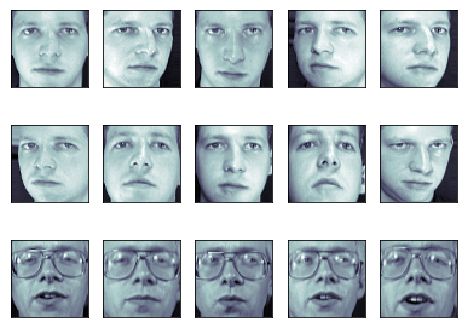

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i], cmap=plt.cm.bone)

.. tip::

   Note is that these faces have already been localized and scaled to a
   common size. This is an important preprocessing piece for facial
   recognition, and is a process that can require a large collection of
   training data. This can be done in scikit-learn, but the challenge is
   gathering a sufficient amount of training data for the algorithm to work.
   Fortunately, this piece is common enough that it has been done. One good
   resource is
   `OpenCV <https://docs.opencv.org/2.4/modules/contrib/doc/facerec/facerec_tutorial.html>`__,
   the *Open Computer Vision Library*.

We'll perform a Support Vector classification of the images. We'll do a
typical train-test split on the images:



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.data,
        faces.target, random_state=0)

print(X_train.shape, X_test.shape)

(300, 4096) (100, 4096)


Preprocessing: Principal Component Analysis
-------------------------------------------

64*64 dimensions is a lot for SVM. We can use PCA to reduce these 1850
features to a manageable size, while maintaining most of the information
in the dataset.



In [ ]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=150, whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

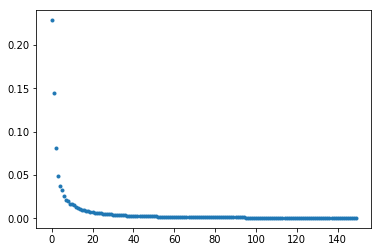

In [ ]:
plt.plot(pca.explained_variance_ratio_,'.')

One interesting part of PCA is that it computes the "mean" face, which
can be interesting to examine:



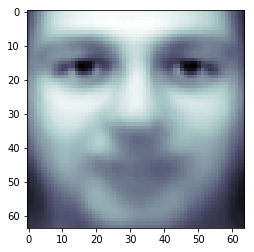

In [ ]:
plt.imshow(pca.mean_.reshape(faces.images[0].shape),
           cmap=plt.cm.bone)

The principal components measure deviations about this mean along
orthogonal axes.



In [ ]:
print(pca.components_.shape)

(150, 4096)


It is also interesting to visualize these principal components:



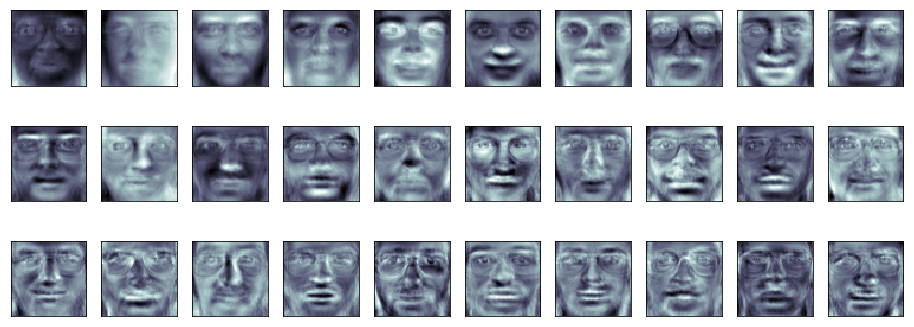

In [ ]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)

##Reconstruct this face with some pca components

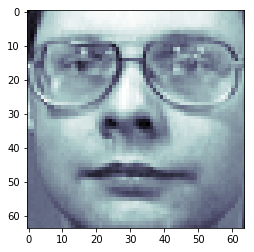

In [ ]:
img = X_test[10]
plt.imshow(img.reshape(faces.images[0].shape), cmap=plt.cm.bone)

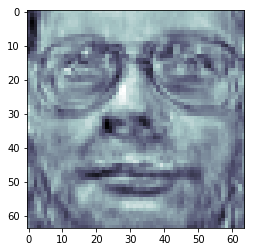

In [ ]:
 # Reshape image to one long vector and subtract the mean vector
import numpy as np
img_pca = pca.transform(img.reshape(1,-1)).reshape(-1)
output = pca.mean_
#The weight is the dot product of the mean subtracted
#image vector with the EigenVector
num_components = 150
for i in range(0,num_components):
    output = output + pca.components_[i] * img_pca[i]
plt.imshow(output.reshape(faces.images[0].shape), cmap=plt.cm.bone)

In [ ]:
#The pca coefficients
img_pca = pca.transform(X_test[0].reshape(1,-1)).reshape(-1)
img_pca[:10]

array([ 0.05164506, -1.2839099 ,  0.7992505 , -0.5595604 ,  0.12947108,
        0.6584965 , -0.26865634,  1.5446354 , -0.5458803 ,  0.12421212],
      dtype=float32)

The components ("eigenfaces") are ordered by their importance from
top-left to bottom-right. We see that the first few components seem to
primarily take care of lighting conditions; the remaining components
pull out certain identifying features: the nose, eyes, eyebrows, etc.

With this projection computed, we can now project our original training
and test data onto the PCA basis:



In [ ]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)

(300, 150)


In [ ]:
print(X_test_pca.shape)

(100, 150)


## Let's visualize the faces in a 2d-pca projection

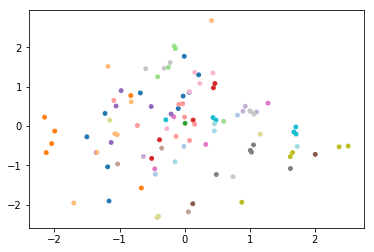

In [ ]:
pca_2d = decomposition.PCA(n_components=2, whiten=True)
test_2d = pca.fit_transform(X_test)
plt.scatter(test_2d[:,0],test_2d[:,1],s=15,c=y_test, cmap=plt.cm.tab20)

## Doing the Learning: linear regression (note: multi_class{‘auto’, ‘ovr’, ‘multinomial’})

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train_pca, y_train)
#from sklearn import svm
#clf = svm.SVC(C=?)
#clf.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Homework: Try with less pca dimensions: X_train_pca[:,:20] 

Finally, we can evaluate how well this classification did. First, we
might plot a few of the test-cases with the labels learned from the
training set:



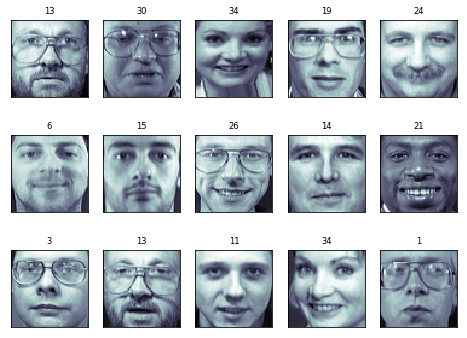

In [ ]:
import numpy as np
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[i, np.newaxis])[0]
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)

The classifier is correct on an impressive number of images given the
simplicity of its learning model! Using a linear classifier on 150
features derived from the pixel-level data, the algorithm correctly
identifies a large number of the people in the images.

Again, we can quantify this effectiveness using one of several measures
from :mod:`sklearn.metrics`. First we can do the classification
report, which shows the precision, recall and other measures of the
"goodness" of the classification:



In [ ]:
from sklearn import metrics
y_pred = clf.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.83      0.91         6
          1       1.00      1.00      1.00         4
          2       0.33      0.50      0.40         2
          3       1.00      1.00      1.00         1
          4       1.00      1.00      1.00         1
          5       1.00      1.00      1.00         5
          6       1.00      1.00      1.00         4
          7       1.00      0.67      0.80         3
          8       0.00      0.00      0.00         0
          9       1.00      1.00      1.00         1
         10       1.00      1.00      1.00         4
         11       1.00      1.00      1.00         1
         12       1.00      1.00      1.00         2
         13       1.00      1.00      1.00         3
         14       1.00      1.00      1.00         5
         15       0.75      1.00      0.86         3
         17       1.00      1.00      1.00         6
         19       1.00      1.00      1.00   

C:\WPy-3702\python-3.7.0.amd64\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Another interesting metric is the *confusion matrix*, which indicates
how often any two items are mixed-up. The confusion matrix of a perfect
classifier would only have nonzero entries on the diagonal, with zeros
on the off-diagonal:



In [ ]:
print(metrics.confusion_matrix(y_test, y_pred))

[[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 3]]


A Note on Facial Recognition
----------------------------

Here we have used PCA "eigenfaces" as a pre-processing step for facial
recognition. The reason we chose this is because PCA is a
broadly-applicable technique, which can be useful for a wide array of
data types. Research in the field of facial recognition in particular,
however, has shown that other more specific feature extraction methods
are can be much more effective.



## CLUSTERING

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_test_pca)
kmeans.labels_

array([1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 0, 2, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0])

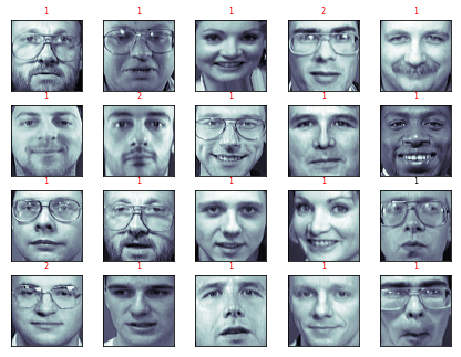

In [ ]:
import numpy as np
fig = plt.figure(figsize=(8, 6))
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
    y_pred = kmeans.predict(X_test_pca[i, np.newaxis])[0]
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)


## Let's visualize the clusters in 2D

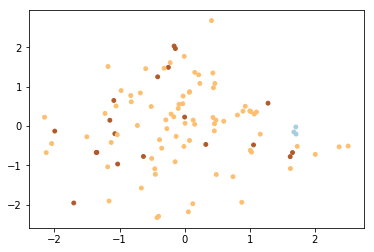

In [ ]:
pca_2d = decomposition.PCA(n_components=2, whiten=True)
test_2d = pca.fit_transform(X_test)
plt.scatter(test_2d[:,0],test_2d[:,1],s=15,c=kmeans.labels_, cmap=plt.cm.Paired)

## Show some faces

This small cluster seems to focus on "beard"

In [ ]:
np.where(kmeans.labels_ == 0)[0]

array([76, 78, 99], dtype=int64)

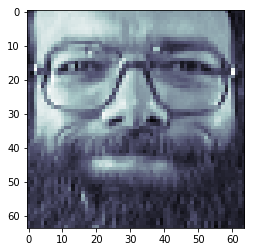

In [ ]:
plt.imshow(X_test[99].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)